In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import slim
from tensorflow.contrib import distributions

In [2]:
BATCH_SIZE = 1000
D_LR = 1e-4
G_LR = 1e-4

In [3]:
### specify mixture model to be learned
# this is the target distribution

target_model = {'n_components':3,
                 'n_dims':2,
                 'weights':[.2,.2,.6],
                 'means':[[-.6,1.6],[-1.2,-1.3],[1.,.6]],
                 'sds':[[.3,.1],[.2,.2],[.2,.6]]
                }

initial_model = {'n_components':3,
                 'n_dims':2,
                 'weights':[1./3,1./3,1./3],
                 'means':[[-1.,1.],[-1.,-1.],[1.,0.]],
                 'sds':[[.6,.6],[.6,.6],[.6,.6]]
                }

#target_model = initial_model

def mixture_pdf(model):
    dist = distributions.MixtureSameFamily(
        mixture_distribution=distributions.Categorical(
            probs=model['weights']),
        components_distribution=distributions.MultivariateNormalDiag(
            loc=model['means'],       # One for each component.
            scale_diag=model['sds']))  # And same here.
    return dist

mp = mixture_pdf(target_model)
mixlogprob = mp.log_prob
mixsample = mp.sample

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [4]:
# Gumbel-softmax code taken from: 
# https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb

def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
      """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y

In [5]:
# specify the generator that will learn this mixture model

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def softmax(e,axis=1):
    f = tf.exp(e - tf.expand_dims(tf.reduce_max(e,axis=axis),axis=axis))
    return f / tf.expand_dims(tf.reduce_sum(f,axis=axis),axis=axis)

def generator(eps_unif,eps_gauss,gumbel,tau=1e-5,reuse=False):
    """
    Use random noise 'eps' to sample from mixture model
    """
    with tf.variable_scope("generator", reuse=reuse) as scope:
        
        means = slim.model_variable('means',
                                    shape=np.shape(initial_model['means']),
                                    initializer=tf.constant_initializer(initial_model['means'])
                                   )
        
        sds = slim.model_variable('sds',
                                  shape=np.shape(initial_model['sds']),
                                  initializer=tf.constant_initializer(initial_model['sds'])
                                 )
        
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(eps_unif, 256, scope='fc_0')
            
            for i in range(5):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, initial_model['n_components'], activation_fn=None, scope='T',
                                 weights_initializer=tf.constant_initializer(0.))
        
        #slim.stack(eps_unif, slim.fully_connected, 
        #           [10,10,initial_model['n_components']], 
        #           activation_fn=tf.nn.elu, 
        #           scope='fc'
        #          )
        
        #pi = softmax(T,axis=1)
        #f = (tf.log(pi) + gumbel) / tau
        #weights = softmax(f,axis=1)
        
        #weights = tf.nn.softmax((tf.nn.log_softmax(T,axis=1) + gumbel)/tau,axis=1)
        
        #weights = gumbel_softmax_sample(T, temperature=tau)
        weights = gumbel_softmax_sample(tf.nn.log_softmax(T,axis=1), temperature=tau)
        
        y = tf.reduce_sum(weights[:,:,tf.newaxis] * means[tf.newaxis,:,:], axis=1)
        y += tf.reduce_sum(weights[:,:,tf.newaxis] * sds[tf.newaxis,:,:],axis=1) * eps_gauss
        
        return y, weights

eps_unif = tf.random_uniform((BATCH_SIZE,initial_model['n_components']),dtype=tf.float32)
eps_gauss = tf.random_normal((BATCH_SIZE,initial_model['n_dims']),dtype=tf.float32)
gumbel = -tf.log(-tf.log(tf.random_uniform((BATCH_SIZE,initial_model['n_components']),dtype=tf.float32)))

y, weights = generator(eps_unif,eps_gauss,gumbel)

In [6]:
# specify the reference distribution. we need to both evaluate and sample

ref = distributions.MultivariateNormalDiag(
    loc=[0.,0.],
    scale_diag=[2.5,2.5]
)

reflogprob = ref.log_prob
refsample = ref.sample(sample_shape=BATCH_SIZE)

In [7]:
refsample

<tf.Tensor 'MultivariateNormalDiag_1/sample/affine_linear_operator/forward/add:0' shape=(1000, 2) dtype=float32>

In [7]:
# visualize the target model

with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    initial_samples = s.run(mixsample(sample_shape=BATCH_SIZE))

In [8]:
# specify the adversary, which will learn the likelihood ratio
# between generator samples and reference samples

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def adversary(y, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse) as scope:
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(y, 256, scope='fc_0')

            for i in range(5):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, 1, activation_fn=None, scope='T',
                                weights_initializer=tf.constant_initializer(0.))
        T = tf.squeeze(T, [1])
        return T

In [9]:
# prepare for run

dref = adversary(refsample)
dy = adversary(y,reuse=True)

dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "adversary")
gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")

dloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=dy, labels=tf.ones_like(dy))
    + tf.nn.sigmoid_cross_entropy_with_logits(logits=dref, labels=tf.zeros_like(dref))
)

gloss = tf.reduce_sum(reflogprob(y) - mixlogprob(y) + dy, axis=0)

dtrain_step = tf.train.AdamOptimizer(D_LR).minimize(dloss,var_list=dvars)
gtrain_step = tf.train.AdamOptimizer(G_LR).minimize(gloss,var_list=gvars)

In [10]:
from tqdm import tqdm_notebook, tnrange
import os

outdir = './out_mix_notebook'
if not os.path.exists(outdir):
    os.makedirs(outdir)

def run_training(sess, niter=10000, ninitial=100):
    
    # consider a burn-in period for the discriminator before going to the generator
    
    burn_in = tqdm_notebook(range(ninitial))
    
    for i in burn_in:
        
        y_,refsample_,dref_,dy_,dloss_,_ = s.run([y,refsample,dref,dy,dloss,dtrain_step])
        
        burn_in.set_description("dloss=%.3f"  % (dloss_))

    progress = tqdm_notebook(range(niter))

    for i in progress:
              
        y_,refsample_,dref_,dy_,dloss_,_ = s.run([y,refsample,dref,dy,dloss,dtrain_step])
        _ = s.run([gtrain_step])
        
        #print(np.shape(y_),np.shape(refsample_))
            
        progress.set_description("dloss=%.3f"  % (dloss_))
        
        if i%500 == 0:
            fig,ax=plt.subplots(1,4,figsize=(16,4))
            
            ax[0].scatter(initial_samples[:,0],initial_samples[:,1],alpha=.3)
            ax[0].set_xlim([-4,4])
            ax[0].set_ylim([-4,4])
            ax[0].set_title('Target Samples')
            
            ax[1].scatter(y_[:,0],y_[:,1],alpha=.3)
            ax[2].scatter(refsample_[:,0],refsample_[:,1],alpha=.3)
            ax[1].set_xlim([-4,4])
            ax[1].set_ylim([-4,4])
            ax[2].set_xlim([-4,4])
            ax[2].set_ylim([-4,4])
            
            ax[1].set_title('Generated Samples')
            ax[2].set_title('Reference Samples')
            
            #ax[2].scatter(y_[:,0],y_[:,1],alpha=.3,c=dy_,cmap='Blues')
            ax[3].scatter(refsample_[:,0],refsample_[:,1],alpha=.3,c=dref_,cmap='plasma')
            
            ax[3].set_xlim([-4,4])
            ax[3].set_ylim([-4,4])
            
            ax[3].set_title('Discriminator on Ref')
            
            #ax[1].hist(y_,50,alpha=.3,normed=True)
            #ax[1].hist(refsample_,50,alpha=.3,normed=True)
            #ax[1].set_xlim([-4,4])
            plt.savefig('out_mix_2d/iter_%i.png' % i)

KeyboardInterrupt: 

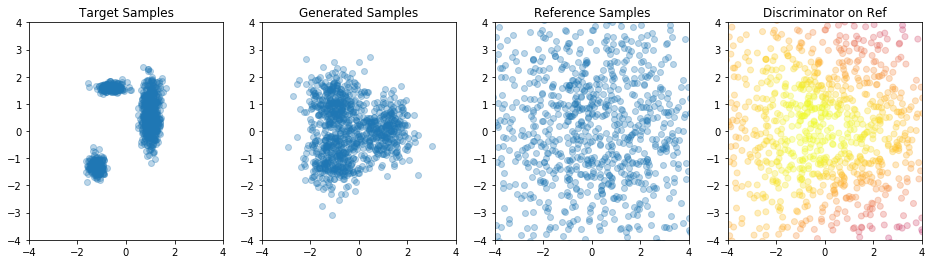

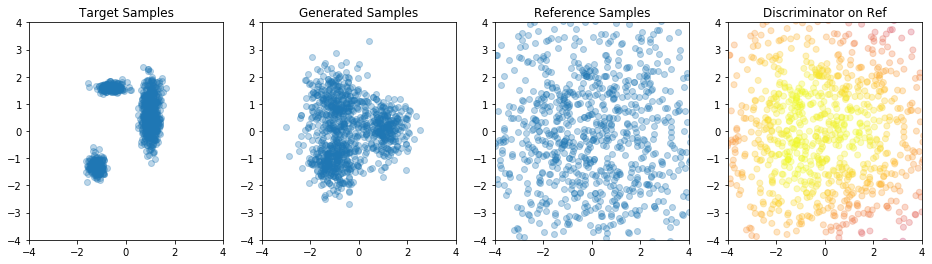

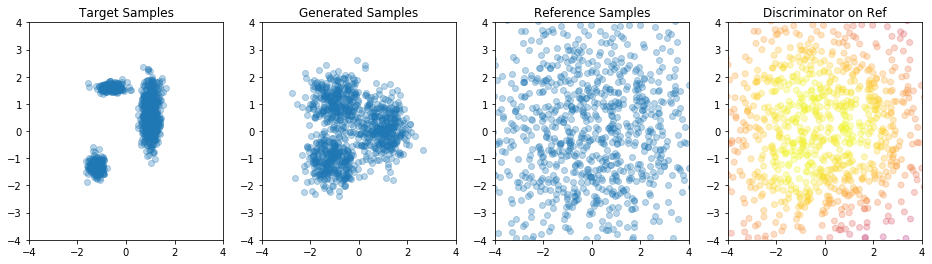

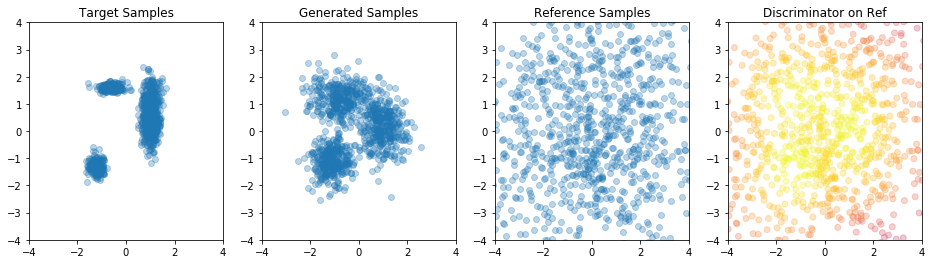

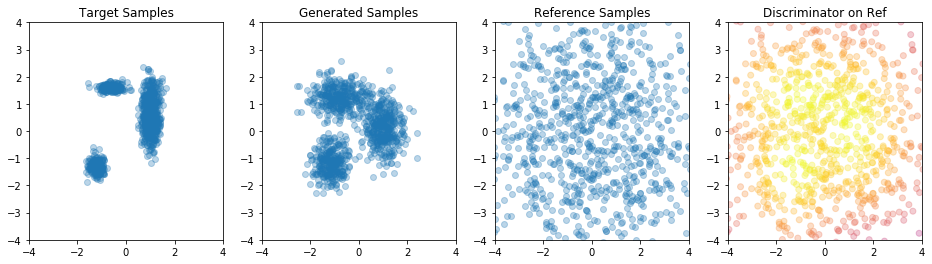

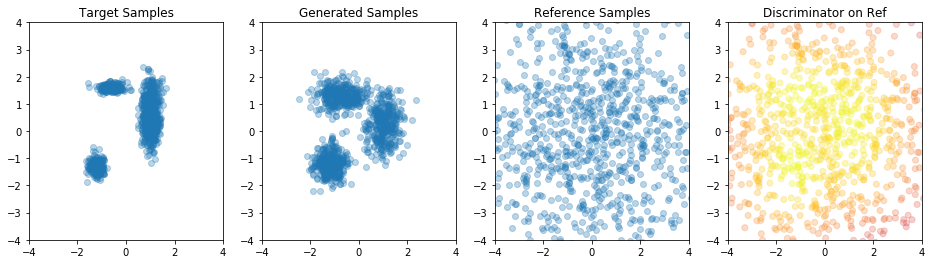

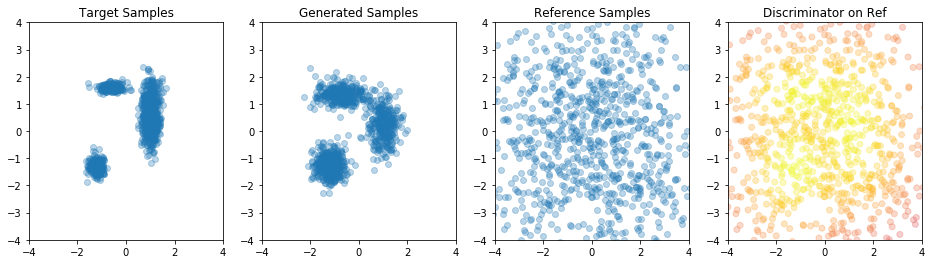

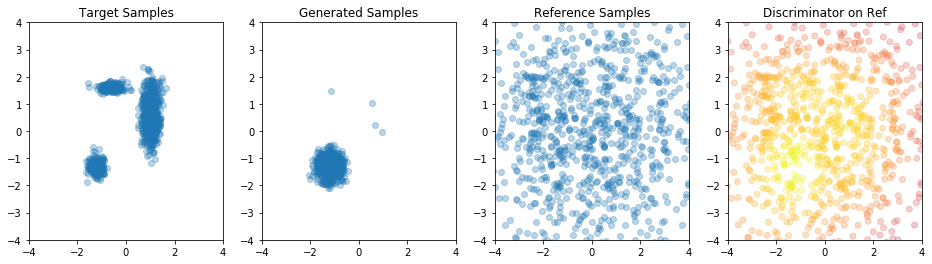

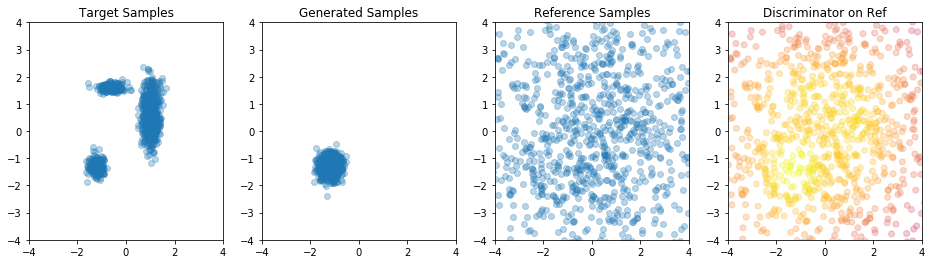

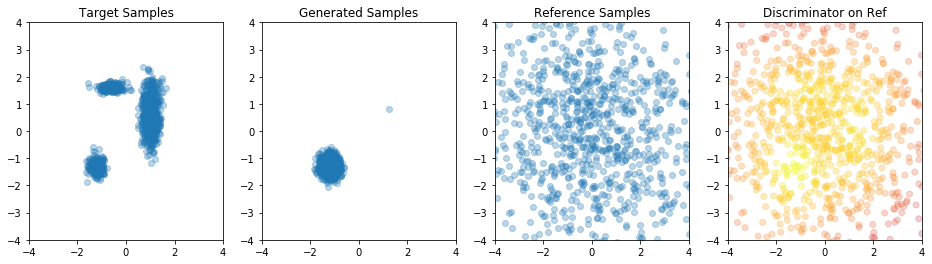

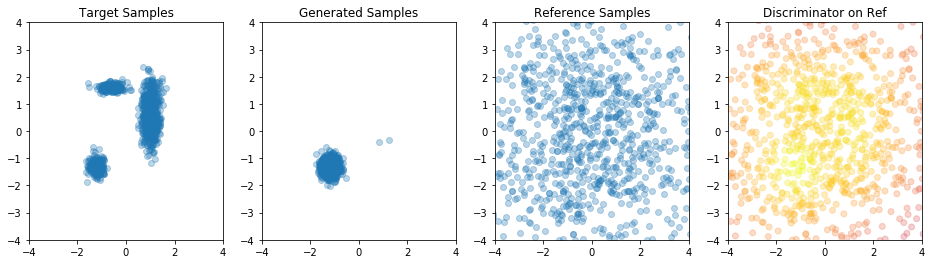

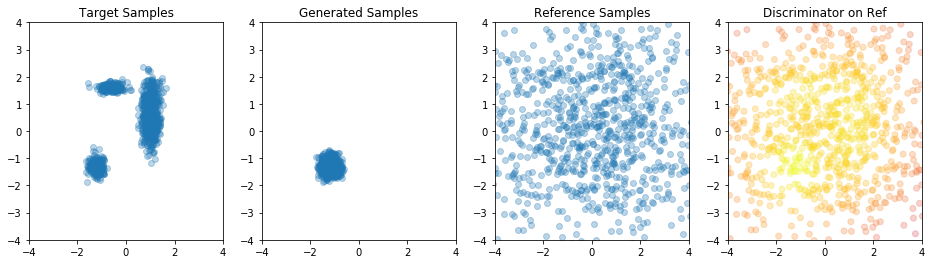

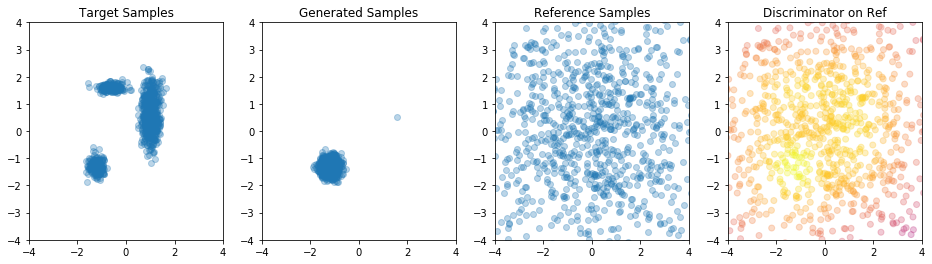

In [11]:
try:
    s.close()
except NameError:
    pass
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())
run_training(s,niter=10000)